In [1]:
import sys
import geoopt
import torch
import numpy as np
import pytest
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

Use `geoopt` to do line search optimization where parameters are constrained to manifolds. 

As example we will try to find the basis of a matrix $A$ in which it has the smallest 1-norm by minimizing $\|XAY\|_1$ where $X,Y$ are orthogonal

In [2]:
sphere = geoopt.manifolds.Sphere()
torus = geoopt.manifolds.ProductManifold(*[(sphere,10)]*2)
point = torus.random(20)
point

Tensor on (Sphere)x(Sphere) manifold containing:
tensor([ 0.1802,  0.0489, -0.1967, -0.1905, -0.2777, -0.7367,  0.2597, -0.4321,
        -0.0679,  0.1077,  0.0419, -0.1571,  0.1406, -0.7204,  0.1741,  0.1356,
         0.0968, -0.4010,  0.2169, -0.4110])

In [84]:
X

Tensor on Stiefel(canonical) manifold containing:
tensor([[-0.3222,  0.4904, -0.1950, -0.1220,  0.0918, -0.5128,  0.0651, -0.3955,
         -0.1168,  0.3963],
        [ 0.0311, -0.3741,  0.0174, -0.4994,  0.1924, -0.4576,  0.0878,  0.4129,
         -0.4292, -0.0225],
        [ 0.6981,  0.2145, -0.0979,  0.3510,  0.0195, -0.0076,  0.1177, -0.0357,
         -0.5489,  0.1308],
        [-0.1244,  0.3582, -0.0429, -0.1676, -0.5737,  0.2158,  0.2791,  0.5424,
         -0.0509,  0.2755],
        [ 0.2637, -0.3547,  0.5138, -0.0518, -0.3210, -0.1975,  0.1880, -0.2628,
          0.2364,  0.4855],
        [ 0.1826,  0.4104,  0.4056,  0.1313,  0.4514, -0.2442,  0.0447,  0.4317,
          0.4060,  0.0032],
        [-0.3227, -0.1493,  0.1103,  0.6665, -0.3268, -0.4579, -0.1222,  0.2036,
         -0.1437, -0.1542],
        [ 0.0451,  0.3069,  0.4960, -0.2794, -0.2395,  0.0213, -0.6346, -0.1066,
         -0.2717, -0.1844],
        [-0.2990, -0.1626,  0.1560,  0.2018,  0.3641,  0.3603, -0.2874,  0.166

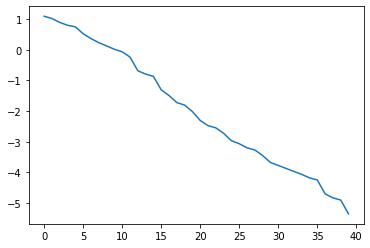

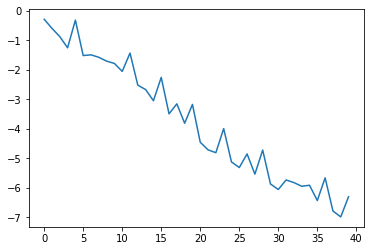

In [202]:
# as test do orthogonal Procrustes problem, because we know closed-form solution
(n,m) = (10,20)
stiefel = geoopt.manifolds.Stiefel()
A = torch.randn(n,m,dtype=torch.float64)
Q = stiefel.random((n,n),dtype=torch.float64)
B = Q@A

with torch.no_grad():
    X = stiefel.random((n,n),dtype=torch.float64)
    X.requires_grad=True

def closure():
    optim.zero_grad()
    loss = (X@A-B).norm()
    loss.backward()
    return loss.item()
optim = geoopt.optim.RiemannianLineSearch([X],line_search_method='wolfe')
losses=[]
for i in range(500):
    losses.append(optim.step(closure))
    if losses[-1]<1e-5:
        break

plt.plot(np.log10(losses))
plt.figure()
log_step_sizes = (np.log10([x if (x is not None) else 1 for x in optim.step_size_history]))
plt.plot(log_step_sizes)
plt.show()

In [156]:
X.dtype

torch.float64

5%|▍         | 47/1000 [00:00<00:02, 321.63it/s]


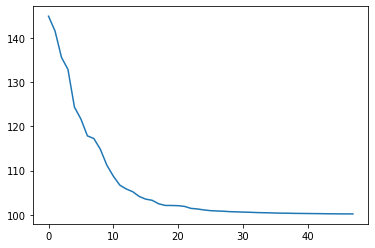

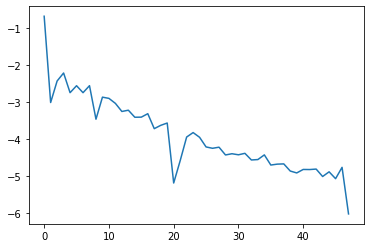

In [157]:
(n,m) = (10,20)
BATCH_SIZE=16
A = torch.randn(n,m)
stiefel = geoopt.manifolds.Stiefel()

X = stiefel.random((n,n))
X.requires_grad=True
Y = stiefel.random((m,m))
Y.requires_grad=True

stief_prod = geoopt.manifolds.ProductManifold((stiefel,(n,n)),(stiefel,(m,m)))
XY = stief_prod.random(n**2+m**2)
XY.requires_grad=True

def closure():
    optim.zero_grad()

    loss = (X@A@Y).norm(p=1)
    loss.backward()

    return loss.item()

optim = geoopt.optim.RiemannianLineSearch([X,Y],line_search_method='armijo')
losses = []
for i in tqdm(range(1000)):
    losses.append(optim.step(closure))
    if optim.step_size_history[-1]<1e-6:
        break


plt.plot(losses)
plt.figure()
log_step_sizes = (np.log10([x if (x is not None) else 1 for x in optim.step_size_history]))
plt.plot(log_step_sizes)
plt.show()

In [158]:
optim.derphi_(0.1)

tensor(-265.1171, grad_fn=<AddBackward0>)